In [80]:
import pandas as pd
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt

In [42]:
# read in child care data
df = pd.read_csv('data/modified/geocoded_childcare_centers.csv')

drop_col = ['Unnamed: 0', 'License Number', 'License Type', 'Name of Program', 
            'AddressLine1', 'AddressLine2', 'AddressLine3', 'City', 'State', 'Zip',
            'County', 'Phone', 'License Status', 'License Holder',
            'Type Of License', 'Restrictions', 'Services', 'Licensing Authority',
            'Initial Effective Date', 'Current Effective Date', 'Expiration Date',
            'License Holder Lives Onsite', 'Unnamed: 22', 'full_address',
            'location']
df.drop(columns=drop_col, inplace=True)

In [43]:
from shapely.geometry import Point

# create geodataframe with geometry points
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude'], crs="EPSG:4326"))
gdf.shape

(1775, 4)

In [44]:
# read in census block group shapefile
shp_df = gpd.read_file('data/original/tl_2021_27_bg/tl_2021_27_bg.shp')
shp_df['GEOG_UNIT'] = shp_df['GEOID']
shp_df = shp_df.astype({'GEOG_UNIT':'int64'})
shp_df = shp_df.set_index(['GEOG_UNIT']).sort_index()
drop_col = ['STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'GEOID', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 
            'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON']
shp_df.drop(columns=drop_col, inplace=True)
shp_df.to_crs(4326, inplace=True)

In [47]:
# read in ACS data and join to shp coords
acs_df = pd.read_excel('data/modified/ACS.xlsx')
acs_df = acs_df.astype({'GEOG_UNIT':'int64'})
acs_df = acs_df.set_index(['GEOG_UNIT']).sort_index()

# drop unused cols
drop_col = ['GEOG_LEVEL', 'GEOID', 'GEOID2', 'SUMLEV', 'GEONAME',
            'GEOCOMP', 'STATE', 'COUNTY', 'TRACT', 'BLKGRP', 'TCFLAG', 'HUINTRVWS',
            'PERINTRVWS', 'SOURCE', 'YEAR', 'POPTOTAL', 'PCI',
            'MEANHHINC', 'MEDIANHHI', 'POVERTYN', 'POVERTY150', 'POV150_185',
            'POVDENOM', 'POV100RATE', 'POV150RATE', 'POV185RATE']
acs_df.drop(columns=drop_col, inplace=True)

# join ACS data to shapefile to get geometries
acs_merge_df = pd.merge(acs_df, shp_df, left_index=True, right_index=True)
# convert dataframe to Geopandas dataframe
acs_gdf = gpd.GeoDataFrame(acs_merge_df, geometry=acs_merge_df['geometry'])
acs_gdf.shape

(4706, 2)

In [71]:
cbg_df = gpd.sjoin(acs_gdf, gdf, how='left')
cbg_df.drop(columns=['index_right', 'latitude', 'longitude'], inplace=True)
cbg_df.shape

(5182, 3)

In [72]:
# can't aggregate with geometries so set them aside to join back later
geo_df = cbg_df[['geometry']].copy()

# drop duplicates from join
geo_df.drop_duplicates(inplace=True)

# drop the geometry column from dataframe
cbg_df.drop(columns=['geometry'], inplace=True)

In [76]:
# aggregate to census block group
tmp_df = cbg_df.groupby('GEOG_UNIT').sum()

# rejoin geometries
final_cbg_df = pd.merge(tmp_df, geo_df, left_index=True, right_index=True)

# convert dataframe to Geopandas dataframe
final_cbg_df = gpd.GeoDataFrame(final_cbg_df, geometry=final_cbg_df['geometry'])

In [77]:
final_cbg_df.head()

,POPUNDER5,Capacity,geometry
GEOG_UNIT,,,
270017701001,24,0.0,"POLYGON ((-93.44836 46.77306, -93.44823 46.773..."
270017701002,23,0.0,"POLYGON ((-93.57482 46.67947, -93.57473 46.679..."
270017701003,24,0.0,"POLYGON ((-93.70840 46.57580, -93.70822 46.575..."
270017702001,17,0.0,"POLYGON ((-93.77747 46.75248, -93.77742 46.754..."
270017702002,19,0.0,"POLYGON ((-93.77836 46.65696, -93.77819 46.667..."


In [78]:
final_cbg_df['excess_pop_under5'] = final_cbg_df['POPUNDER5'] - final_cbg_df['Capacity']

Text(0.5, 1.0, 'Excess Population Under 5')

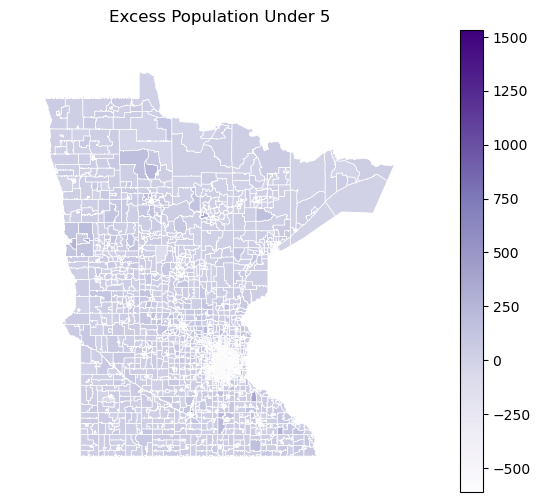

In [82]:
# set the map projection
proj = gplt.crs.WebMercator()


gplt.choropleth(
    final_cbg_df,
    hue='excess_pop_under5',
    cmap='Purples', linewidth=0.5,
    edgecolor='white',
    legend=True,
    projection=proj
)
plt.title("Excess Population Under 5")

In [83]:
# set boundry to Hennepin County
henn_df = gpd.read_file('data/original/Hennepin_County_Boundary/Hennepin_County_Boundary.shp')
henn_df.to_crs(4326, inplace=True)

# join only where within Hennepin County
henn_only_df = gpd.sjoin(final_cbg_df, henn_df)

Text(0.5, 1.0, 'Excess Population Under 5')

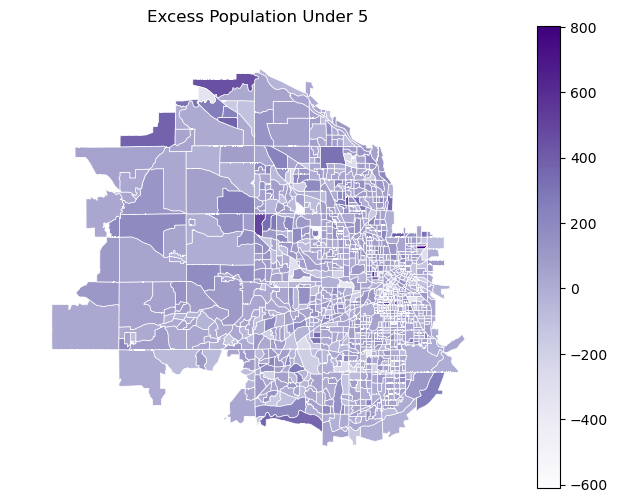

In [85]:
# set the map projection
proj = gplt.crs.WebMercator()


gplt.choropleth(
    henn_only_df,
    hue='excess_pop_under5',
    cmap='Purples', linewidth=0.5,
    edgecolor='white',
    legend=True,
    projection=proj
)
plt.title("Excess Population Under 5")

AttributeError: 'Polygon' object has no attribute 'x'

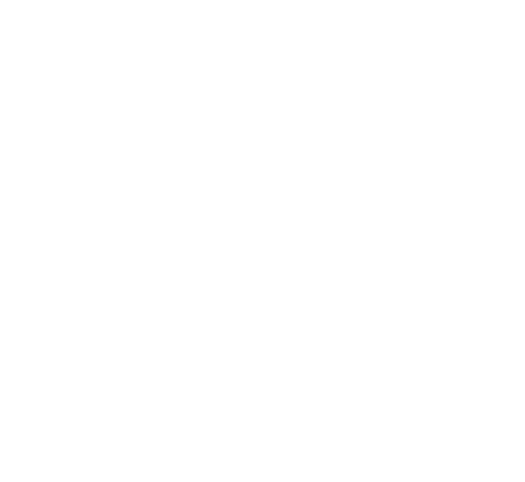

In [86]:
# set the map projection
proj = gplt.crs.WebMercator()


ax = gplt.kdeplot(
    henn_only_df,
    fill=True, cmap='Reds',
    projection=proj, weights=henn_only_df.excess_pop_under5, alpha=0.7)

geoplot.webmap(population, ax=ax)
plt.title('Population Under 5', fontsize=18)